# The Data Incubator Project

My project aims to look at the correlation between Airbnb occupancy in the city of San Francisco and the number of incidents reported by the police of the city.
I believe the Airbnb occupancy rate can be used as a proxy to the number of tourists or visitors present in the city.
We could expect that, if more tourists are present, the crime rate may increase. 
I wish to explore whether this correlation exists and if it does, we can investigate further how the different types of crime relate to the occupancy and if this phenomenon is similar in a less touristy city such as Oakland. We can also investigate if the relation changes in regards to the type of Airbnb client (cheap vs expensive room, single room vs whole house, long vs short stays)
If we find strong correlations we can try to predict the future number of crime incidents in function of the reservations made on Airbnb.

I downloaded the Airbnb data from : http://insideairbnb.com/get-the-data.html
I downloaded all the data concerning year 2018 for San Fransisco. The idea was to use information as close to the scraping date as possible.

Data about police reports for San Fransisco can be found at:
https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783

## Libraries

In [26]:
library(plyr)
library(lubridate)
# TODO: check if libraries still necessary

## Scrape Airbnb Data

NEW: scraping the data will allow me to access airbnb data faster and with no risk of typos. It will be easier to get data from other years and cities.

Decide what data we want to scrape. Here we will scrape data from the city of San Francisco, year 2018.

In [27]:
city <- "San Francisco"
last.date <- "2018-12-31"
start.date <- "2018-01-01"
dateminfile = "2017-12-06" # we need to get the last dataset that contains the 1st of January.
# I looked this up manually

Download the data. If already done (and do not want to download again), comment download line, enter the path to the downloaded file in line under and use that.
If not, use the line to download the files.

In [28]:
source("functions/download_airbnb_files.R")
# newfile.path <- download_airbnb_files(city)
newfile.path <- "/Users/laura/Dropbox/TDI/airbnb_san-francisco"


Open each data set, select the right dates, concatenate them to one datafreame and assign it.

In [29]:
source("functions/open_airbnb_data.R")
# TODO: you have to know the date of the file before the start date you want.
#       ideally: automatically find the most recent file containing that date.
#       or at least force the error with an error message if wrong date.

airbnb.data <- open_airbnb_data(newfile.path,
                                dateminfile = dateminfile,
                                start.date = start.date,
                                last.date = last.date)

Calculate the occupancy rate and add it to a reformated dataframe with one row entry for each day.

In [30]:
source("functions/airbnb_occupancy_day.R")
airbnb.data.occ.day <- airbnb_occupancy_day(airbnb.data)
# plot(airbnb.data.occ.day$occupancy)

Aggregate the data in weeks.

In [31]:
source("functions/airbnb_occupancy_week.R")
airbnb.data.occ.week <- airbnb_occupancy_week(airbnb.data.occ.day)
# plot(airbnb.data.occ.week$occupancy)

## Import and Reshape Police Data

In [32]:
police <- read.csv("police.csv")

Select the data from 2018.

In [33]:
mypolice <-police[ , c("Row.ID", "Incident.Date", "Incident.Category")]
mypolice$Incident.Date <- as.Date(mypolice$Incident.Date)
dp1 <- as.Date("2018-01-01")
dp2 <- as.Date("2018-12-31")

pol2018 <- mypolice[mypolice$Incident.Date %in% dp1:dp2, ]

Count how many incidents there are for each day and reshape the data.

In [34]:
pol.inc <- count(pol2018, c("Incident.Date", "Incident.Category"))
pol.inc.long <- reshape(pol.inc,
                       timevar = "Incident.Category",
                       idvar = c("Incident.Date"),
                       direction = "wide")

Replace the "NA" by the value 0 and create a column with the sum of all incidents of different types.

In [35]:
pol.inc.long[is.na(pol.inc.long)] <- 0
pol.inc.long$total <- apply(as.matrix(pol.inc.long[ , -1]), 1, sum)

We aggregate the data to get weekly counts (Total, Burglar, and Assault).

In [36]:
pol.inc.long.week <- tapply(pol.inc.long$total,
                         week(pol.inc.long$Incident.Date),
                         sum)

pol.bur.week <- tapply(pol.inc.long$freq.Burglary,
                            week(pol.inc.long$Incident.Date),
                            sum)

pol.ass.week <- tapply(pol.inc.long$freq.Assault,
                       week(pol.inc.long$Incident.Date),
                       sum)

## The Plots and Models

We first explore the correlation between the total number of incidents and the occupancy rate of Airbnb. We look at the daily data and the weekly aggregated data.

In [37]:
mod.day <- lm(pol.inc.long$total ~ airbnb.data.occ.day$occupancy)
mod.week <- lm(pol.inc.long.week ~ airbnb.data.occ.week$occupancy)

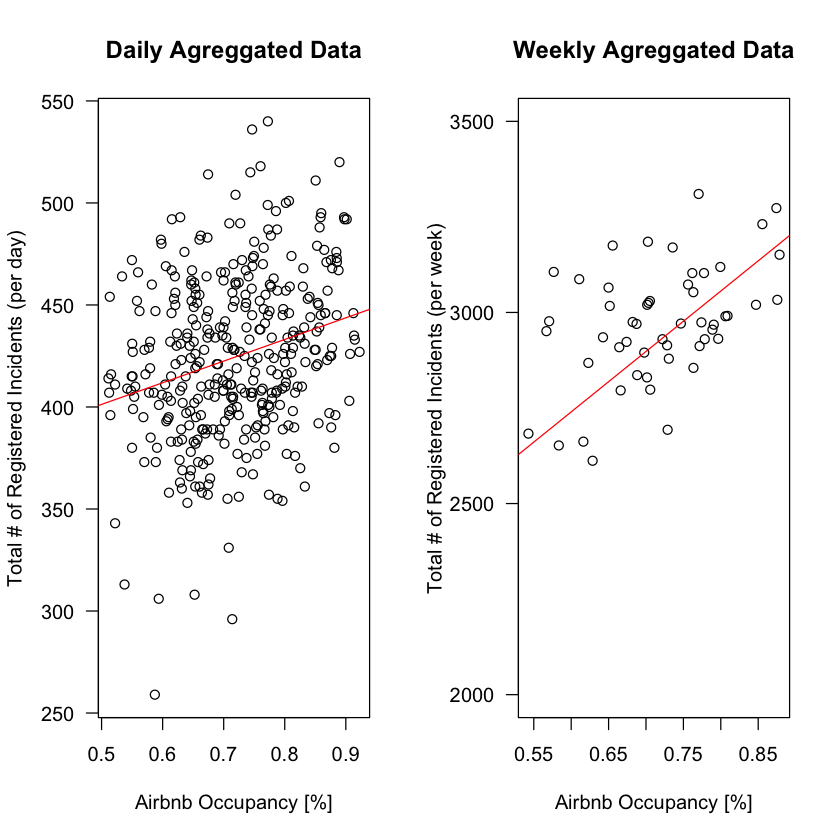

In [38]:
par(mfrow=c(1,2))
plot(pol.inc.long$total ~ airbnb.data.occ.day$occupancy,
     xlab = "Airbnb Occupancy [%]",
     ylab = "Total # of Registered Incidents (per day)",
     main = "Daily Agreggated Data",
     las=1)
abline(a=coef(mod.day)[1],
       b=coef(mod.day)[2],
       col=2)

plot(pol.inc.long.week ~ unlist(airbnb.data.occ.week$occupancy),
     xlab = "Airbnb Occupancy [%]",
     ylab = "Total # of Registered Incidents (per week)",
     ylim = c(2000,3500),
     main = "Weekly Agreggated Data",
     las=1)
abline(a=coef(mod.week)[1],
       b=coef(mod.week)[2],
       col=2)

We observe a positive correlation (statistically significant)

In [39]:
# Uncomment this for summary of the models
# summary(mod.day)
# summary(mod.week)

We now investigate the same correlation if we look at two incidents in particular: burglary and assault.
The idea would be that the number of assaults may increase (tourists are easier preys) but the number of burglaries should stay the same or decrease (the homes are occupied not empty). Let's check!

## Assault and Burglary Plots

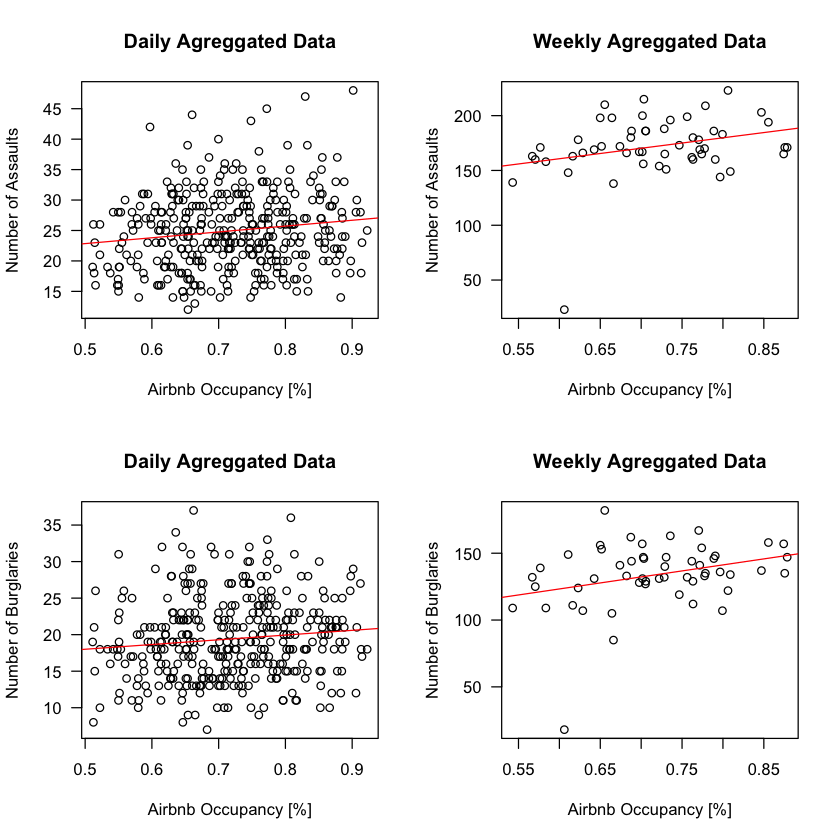

In [40]:
par(mfrow = c(2,2))
mod.ass.day <- lm(pol.inc.long$freq.Assault ~ airbnb.data.occ.day$occupancy)
plot(pol.inc.long$freq.Assault ~ airbnb.data.occ.day$occupancy,
     xlab = "Airbnb Occupancy [%]",
     ylab = "Number of Assaults",
     main = "Daily Agreggated Data",
     las=1)
abline(a=coef(mod.ass.day)[1],
       b=coef(mod.ass.day)[2],
       col=2)

mod.ass.w <- lm(pol.ass.week ~ airbnb.data.occ.week$occupancy)
plot(pol.ass.week ~ airbnb.data.occ.week$occupancy,
     xlab = "Airbnb Occupancy [%]",
     ylab = "Number of Assaults",
     # ylim = c(2000,3500),
     main = "Weekly Agreggated Data",
     las=1)
abline(a=coef(mod.ass.w)[1],
       b=coef(mod.ass.w)[2],
       col=2)

mod.burg.day <- lm(pol.inc.long$freq.Burglary ~ airbnb.data.occ.day$occupancy)
plot(pol.inc.long$freq.Burglary ~ airbnb.data.occ.day$occupancy,
     xlab = "Airbnb Occupancy [%]",
     ylab = "Number of Burglaries",
     main = "Daily Agreggated Data",
     las=1)
abline(a=coef(mod.burg.day)[1],
       b=coef(mod.burg.day)[2],
       col=2)

mod.bur.w <- lm(pol.bur.week ~ unlist(airbnb.data.occ.week$occupancy))
plot(pol.bur.week ~ unlist(airbnb.data.occ.week$occupancy),
     xlab = "Airbnb Occupancy [%]",
     ylab = "Number of Burglaries",
     # ylim = c(2000,3500),
     main = "Weekly Agreggated Data",
     las=1)
abline(a=coef(mod.bur.w)[1],
       b=coef(mod.bur.w)[2],
       col=2)

We observe a positive trend in both cases although the slope for burglary regression is not as steep as that for assault. The effect is not as strong when we look at weekly aggregated data.

In [41]:
coef(mod.burg.day)[2]
coef(mod.ass.day)[2]

airbnb.data.occ.day$occupancy 
                     6.475294

airbnb.data.occ.day$occupancy 
                     9.607038

In [42]:
coef(mod.bur.w)[2]
coef(mod.ass.w)[2]

unlist(airbnb.data.occ.week$occupancy) 
                               90.0713

airbnb.data.occ.week$occupancy 
                      95.51467

## To be continued...